# Modelizado Experimental

Vamos a encontrar el modelo matemático del siguiente sistema usando datos experimentales. 

<img src="planta.jpeg" width="400px">

La planta es un sistema de iluminación con un LED de potencia (actuador) y un LDR (sensor). Este sistema es controlado a través de un Arduino Mega (actualmente Arduino Mega, en la foto Arduino Uno).

Un versión para MATLAB puede ser consultada [aquí](http://cpm222.davinsony.com/modelizado/)

In [1]:
%%capture --no-display

import warnings
warnings.filterwarnings(action='ignore')

try: 
  from control.matlab import *
except:
  !pip install control
  from control.matlab import *

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4,3)

import numpy as np
import sympy as sp
import pandas as pd
import scipy.optimize as op 

sp.init_printing()

## Toma de datos

Para la toma de datos usaremos el código en [lazo_abierto](lazo_abierto/lazo_abierto.ino) para Arduino. Y seguiremos los pasos mostrado a continuación.

- Descargamos el código.
- Subimos el código al Arduino.
- Abrimos el monitor serial.
- Copiamos los datos de un ciclo completo de apagado y prendido.
- Pegamos en un archivo llamado `datos.csv` con nombre de las columnas `t,u,y`.
- Finalmente, importamos los datos en el Colaboratory o Jupyter Notebook con pandas. 

In [2]:
datos = pd.read_csv("datos.csv")

A continuación se muestran algunos datos. 

In [3]:
datos

t    u    y
0    60968004    0  455
1    60972004    0  454
2    60976004    0  455
3    60980004    0  455
4    60984004    0  455
..        ...  ...  ...
253  61980004  255  653
254  61984004  255  653
255  61988004  255  653
256  61992004  255  653
257  61996004  255  653

[258 rows x 3 columns]

## Modelizado experimental

Despues de importar los datos, los extraemos en vectores y graficamos.

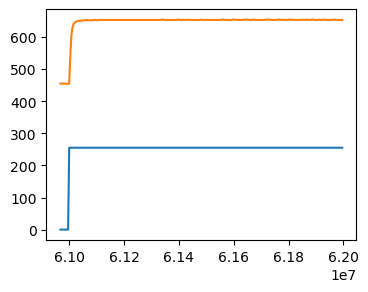

In [4]:
traw = np.array(datos["t"].tolist())
uraw = np.array(datos["u"].tolist())
yraw = np.array(datos["y"].tolist())

plt.plot(traw,uraw,traw,yraw);

Para la construcción del modelo necesitamos tratar los datos, cambiaremos las unidades del tiempo que esta en microsegundos. 

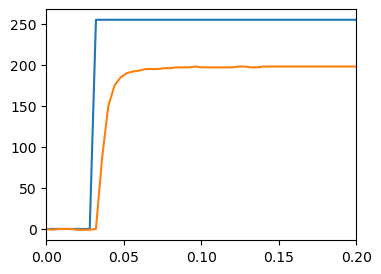

In [5]:
t = (traw - traw[0])/1e6
u = (uraw - uraw[0])
y = (yraw - yraw[0])

plt.plot(t,u,t,y);
plt.xlim((0,0.2));

Por la respuesta del sistema podemos suponer que es un sistema de primer orden con retardo. La función de transferencia para dicho sistema está dada por la expresión: 

$$G(s) = \frac{\gamma}{\tau\,s+1}e^{-\theta\,s}$$

Podemos suponer los valores de los parámetros y modificarlos hasta que las gráficas se parezcan. 

In [6]:
s = tf("s")

gamma = y[-1]/u[-1]
tau   = 0.0044376
theta = 0.004

num,den = pade(theta,n=5)
retardo = tf(num,den)

G = gamma/(tau*s+1)

print("------------------------")
print("Función de transferencia\n")
display(G)
GR = G*retardo

------------------------
Función de transferencia



TransferFunction(array([0.77647059]), array([0.0044376, 1.       ]))

La anterior expresión toma valores encontrados al tanteo. 

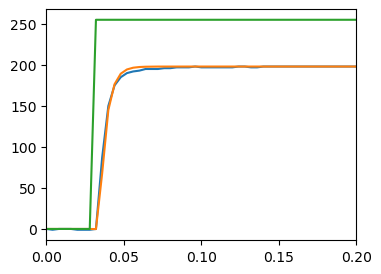

In [7]:
T = np.linspace(t[0],t[-1],num=len(t))
ysim,tsim,_ = lsim(GR,U=u,T=T)

plt.plot(t,y,tsim,ysim,t,u);
plt.xlim((0,0.2));

Se ve que siguen habiendo diferencias entre el modelo y los datos. Aquí, podemos contruir un algoritmo de optimización que minimize el error cuadratico entre las dos respuestas (modelo y datos). 

Estos son los resultados:

In [8]:
def model(x):
  gamma, tau, theta = x
  theta = max(abs(theta),0.001)
  G = gamma/(tau*s+1)
  num,den = pade(theta,n=5)
  retardo = tf(num,den)
  GR = G*retardo
  ysim,tsim,_ = lsim(GR,U=u,T=T)
  return np.sum((y-ysim)**2)

result = op.minimize(model,[0.77,0.005,0.004])
result

      fun: 171.07466223467733
 hess_inv: array([[ 3.05984796e-08,  1.03288890e-09, -3.17140679e-10],
       [ 1.03288889e-09,  3.30702396e-09, -2.06624838e-09],
       [-3.17140679e-10, -2.06624838e-09,  1.95079611e-09]])
      jac: array([-0.18247032,  0.91336441,  2.62592506])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 127
      nit: 8
     njev: 27
   status: 2
  success: False
        x: array([0.77663225, 0.00502317, 0.00301336])

En el anterior resultado encontramos los valores optimizados para los parametros del modelo $\gamma$, $\tau$ y $\theta$. Con estos parámetros podemos verificar la respuesta nuevamente.

In [9]:
gamma, tau, theta = result.x
num,den = pade(theta,n=5)
retardo = tf(num,den)

G = gamma/(tau*s+1)
GR = G*retardo

print("Retardo:",theta)

Retardo: 0.0030133589411103744


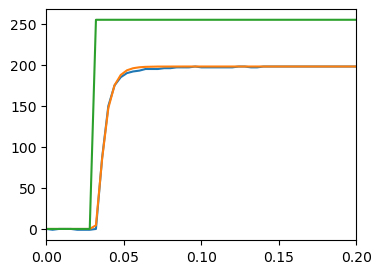

In [10]:
T = np.linspace(t[0],t[-1],num=len(t))
ysim,tsim,_ = lsim(GR,U=u,T=T)

plt.plot(t,y,tsim,ysim,t,u);
plt.xlim((0,0.2));

## Diseño de un controlador (PID)

Para el diseño del controlador podemos usar un controlador PID o diseñar un controlador usando la representación en espacio de estados. Primero usaremos un PID, en este caso usamos un controlador PI, y los parámetros fueron ajustados manualmente. 

[código arduino lazo cerrado](lazo_cerrado/lazo_cerrado.ino)

Controlador PI :


TransferFunction(array([ 2.5, 10. ]), array([1., 0.]))

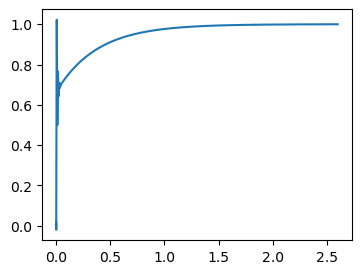

In [37]:
Kp = 2.5
Ki = 10
Kd = 0.00
K  = Kp + Ki/s + Kd*s

print("Controlador PI :")
display(K)
CPID = feedback(K*GR,1)
yy,tt = step(CPID)
plt.plot(tt,yy); 

In [38]:
'''
plt.axhline(y=0, color='k', linestyle='-')
plt.axvline(x=0, color='k', linestyle='-')
plt.plot(np.real(zero(retardo)),np.imag(zero(retardo)),"ob");
plt.plot(np.real(pole(retardo)),np.imag(pole(retardo)),"xb");
plt.plot(np.real(zero(G)),np.imag(zero(G)),"or");
plt.plot(np.real(pole(G)),np.imag(pole(G)),"xr");
plt.plot(np.real(zero(CPID)),np.imag(zero(CPID)),"og");
plt.plot(np.real(pole(CPID)),np.imag(pole(CPID)),"xg");
plt.xlim((-4000,0))
'''
print("Información de la respuesta a un escalón:\n")

stepinfo(CPID)

Información de la respuesta a un escalón:



{'RiseTime': 0.0025980221962962294,
 'SettlingTime': 1.0631106827244172,
 'SettlingMin': 0.4995665080555242,
 'SettlingMax': 1.0219807319464205,
 'Overshoot': 2.1980731946420473,
 'Undershoot': 2.024617961818068,
 'Peak': 1.0219807319464205,
 'PeakTime': 0.007274462149629443,
 'SteadyStateValue': 1.0}

# Diseño de un controlador por Espacio de Estados

Para el diseño del controlador, debemos convertir la función de transferencia en una representación en espacio de estados:

In [13]:
SS = tf2ss(G)
SS

StateSpace(array([[-199.07744763]]), array([[1.]]), array([[154.60996579]]), array([[0.]]))

Donde la Matriz A es: 

In [14]:
A = sp.Matrix(SS.A)
B = sp.Matrix(SS.B)
C = sp.Matrix(SS.C)

display(A)

[-199.077447630764]

Aquí tenemos que el valor propio de la matriz es igual al polo del sistema representado en función de transferencia.

In [15]:
pole(G)

array([-199.07744763+0.j])

Para el diseño de un controlador en espacio de estados podemos verificar si el sistema es completamente controlable, calculando la matriz de controlabilidad y verificando que el rango de la matriz es igual al número de variables de estado. En este caso el rango es $1$.

In [16]:
Gamma = ctrb(SS.A,SS.B)
display(Gamma)

matrix([[1.]])

Teniendo un sistema completamente controlable, podemos ubicar los polos del sistema en lazo cerrado donde queramos. Recordemos que para esto la realimentación se hace desde el vector de estado:

![Lazo Cerrado](lazo-cerrado.png)

Para esto vamos a calcular la ecuación característica del sistema en lazo cerrado con variable en los elementos del controlador y vamos a igualarlas con la ecuación caracteristica resultante del posicionamiento de polos. 

Para calcular la ecuación caracteristica usaremos la expresión

$$\text{det}\left(s\mathbb{I}-(A-BK)\right) = 0$$

In [17]:
k,symS = sp.symbols("k,s")
K = sp.Matrix([[k]])

print("--------")
print("Matriz K\n")
display(K)

Ac = A-B*K

print("\n-----------")
print(  "Matriz A-BK\n")
display(Ac)

det = sp.Eq((symS*sp.eye(1) - Ac).det(),0)

print("\n-----------------------")
print(  "Ecuación característica\n")
display(det)

--------
Matriz K



[k]


-----------
Matriz A-BK



[-k - 199.077447630764]


-----------------------
Ecuación característica



Si quisieramos ubicar el polo en $s=-250$ deberemos tener un polinomio tipo:

$$s+250 = 0$$

luego:

In [18]:
comp1 = sp.Eq(sp.Poly(det.lhs,symS).coeffs()[1],250)
display(comp1)

de aquí:

In [19]:
sol = sp.Eq(k,sp.solve(comp1,k)[0])
display(sol)

Remplazando el valor de $k$ en la matriz dinámica en lazo cerrado tendremos: 

In [20]:
Ac = Ac.subs({k:sol.rhs})
display(Ac)

[-250.0]

Tendremos entonces una representación en espacio de estados para el sistema en lazo cerrado de la siguiente forma: 

In [21]:
SS.A = np.array(Ac).astype(np.float64)
display(SS)

StateSpace(array([[-250.]]), array([[1.]]), array([[154.60996579]]), array([[0.]]))

Con este tipo de sistema, la constante de tiempo del sistema es: 

$$\tau = 1/250 = 4 \text{ milisegundos}$$

Es decir un tiempo de establecimiento de $t_s = 20 \text{ ms}$

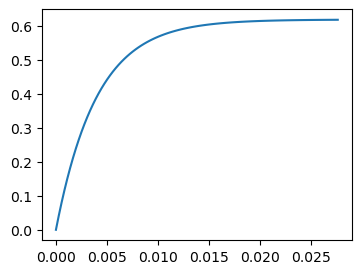

In [22]:
y,t = step(SS)
plt.plot(t,y);

Podemos ver que el tiempo de respuesta es correcto pero el sistema no llega al objetivo. 

Para esto tenedremos que generar otro lazo cerrado e integrar la señal de error $e$. 

![Lazo Cerrado con Integrador](lazo-cerrado-con-integrador.png)

El recuadro azul tiene la siguiente representación en espacio de estados: 

$$
\begin{align}
\dot{x} &= (A-BK)\,x + w \\
y &= C\,x 
\end{align}
$$

del diagrama de bloques externo al recuadro tendremos las siguientes expresiones:

$$e=r-y=r-C\,x=\dot{x}_N \qquad w = K_e\,x_N$$

combinando las expresiones:

$$
\begin{align}
\dot{x} &= (A-BK)\,x + K_e\,x_N \\
\dot{x}_N &= -C\,x + r \\
y &= C\,x 
\end{align}
$$

Si representamos el sistema de manera matricial:

$$
\begin{align}
\begin{bmatrix}
\dot{x} \\
\dot{x}_N
\end{bmatrix}
&= 
\begin{bmatrix}
A-BK & K_e\\
-C & 0
\end{bmatrix}&
\begin{bmatrix}
x \\
x_N
\end{bmatrix}&
+
\begin{bmatrix}
0 \\
1
\end{bmatrix}r \\
y &= \begin{bmatrix}
C & 0
\end{bmatrix}&
\begin{bmatrix}
x \\
x_N
\end{bmatrix}&
\end{align}
$$

La nueva matriz dinámica para este sistema será:

In [23]:
ke = sp.symbols("K_e")

AI = sp.Matrix([[(A-B*K)[0],ke],[-C[0],0]])
display(AI)

⎡-k - 199.077447630764  Kₑ⎤
⎢                         ⎥
⎣  -154.609965793313    0 ⎦

Con la siguiente ecuación caracteristica:

In [24]:
det2 = sp.Eq((symS*sp.eye(2)-AI).det(),0)
display(det2)

P1 = sp.Poly(det2,symS)

Creamos una ecuación característica con los polos arbitrarios:

In [25]:
eq1 = sp.Eq((symS+250)*(symS+50),0)
display(eq1)
eq2 = sp.expand(eq1)
display(eq2)
P2 = sp.Poly(eq2,symS)

Igualamos los coefficientes de las dos ecuaciones características:

In [26]:
cP1 = P1.coeffs()
cP2 = P2.coeffs()

print("---------------------")
print("Sistema de ecuaciones\n")
for i,c in enumerate(cP1):
  if i > 0:
    display(sp.Eq(cP1[i],cP2[i]))
  if i == 1:
    eqs = {sp.Eq(cP1[i],cP2[i])}
  if i > 1:
    eqs.add(sp.Eq(cP1[i],cP2[i]))

print("\n---------------------------")
print(  "Valores para el controlador\n")

ks = sp.solve(eqs,{k,ke})
display(ks)

---------------------
Sistema de ecuaciones




---------------------------
Valores para el controlador



Encontrando los valores del controlador, remplazamos en la matriz dinámica.

In [27]:
AI2 = AI.subs(ks)
AIn = np.array(AI2).astype(np.float64)
print("Matriz A\n")
display(AI2)

Matriz A



⎡     -300.0        80.8486046540516⎤
⎢                                   ⎥
⎣-154.609965793313         0        ⎦

Verificamos que los valores propios si correspondan a los polos deseados: 

In [28]:
np.linalg.eig(AIn)

(array([-250.,  -50.]),
 array([[-0.8504964 , -0.30770401],
        [-0.52598087, -0.95148213]]))

Construyamos las matrices adicionales para el sistema:

In [29]:
BIn = np.matrix([[0],[1]])
print("Matriz B\n")
sp.Matrix(BIn)

Matriz B



⎡0⎤
⎢ ⎥
⎣1⎦

In [30]:
CIn = np.matrix([[SS.C[0,0],0]])
print("Matriz C\n")
sp.Matrix(CIn)

Matriz C



[154.609965793313  0]

Luego nuestro sistema completo será

In [31]:
DIn = np.matrix([[0]])
SSI = ss(AIn,BIn,CIn,DIn)
display(SSI)

<LinearIOSystem:sys[1178]:['u[0]']->['y[0]']>

Respuesta a un escalón


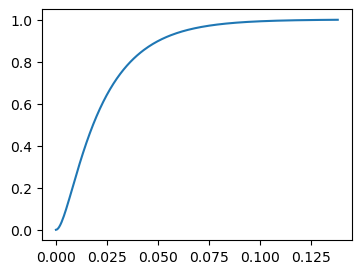

In [40]:
print("Respuesta a un escalón")
y,t = step(SSI)
plt.plot(t,y);

## Implementación
Para implementar en Arduino el controlador en espacio de estados debemos considerar:

![Lazo Cerrado con Integrador](lazo-cerrado-con-integrador.png)

Del diagrama de bloque tenemos que la acción $u$ es:

$$u = K_e\int_0^t e(\tau)\,d\tau - k \,x(t)$$ 

con $e(t)=r-y(t)$ y $x(t) = C^{-1}\, y(t)$. 

Esta ecuación se puede programar de la siguiente forma: 

In [33]:
nke  = ks[ke]
nkp  = ks[k]/SSI.C[0,0]

print("""
float ke = %f;
float kp = %f;

float y = 0;
float u = 0;
float ref   = 500;
float error = 0;
float eSum  = 0;
float dt = 0.001;

void control_loop() {

  error = ref - y;
  eSum += error * dt;
  u = ke * eSum + kp * y;

}
""" % (nke,nkp))


float ke = 80.848605;
float kp = 0.652756;

float y = 0;
float u = 0;
float ref   = 500;
float error = 0;
float eSum  = 0;
float dt = 0.001;

void control_loop() {

  error = ref - y;
  eSum += error * dt;
  u = ke * eSum + kp * y;

}



[código arduino lazo cerrado](lazo_cerrado/lazo_cerrado.ino) para el espacio de estados.

La implemntación del controlador en espacio de estado para este sistema es similar al controlador PID, luego podemos usar los mismos valores: 

Controlador PI :


TransferFunction(array([ 0.65, 81.  ]), array([1, 0]))

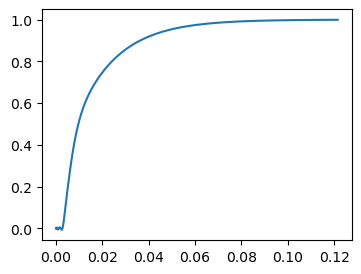

In [36]:
Kp = 0.65 
Ki = 81 
K  = Kp + Ki/s 

print("Controlador PI :")
display(K)
CPID = feedback(K*GR,1)
yy,tt = step(CPID)
plt.plot(tt,yy); 